# IEEE Fraud detection adversarial validation [LGBM]

Giskard is an open-source framework for testing all ML models, from LLMs to tabular models. Don’t hesitate to give the project a [star on GitHub](https://github.com/Giskard-AI/giskard) ⭐️ if you find it useful!

In this notebook, you’ll learn how to create comprehensive test suites for your model in a few lines of code, thanks to Giskard’s open-source Python library.

Use-case:

* IEEE Fraud detection train/test data binary classification task.
* [Reference notebook](https://www.kaggle.com/code/jtrotman/ieee-fraud-adversarial-lgb-split-points/notebook)
* [Dataset](https://www.kaggle.com/code/jtrotman/ieee-fraud-adversarial-lgb-split-points/input)

Outline:  

* Detect vulnerabilities automatically with Giskard’s scan
* Automatically generate & curate a comprehensive test suite to test your model beyond accuracy-related metrics
* Upload your model to the Giskard Hub to:  

    * Debug failing tests & diagnose issues
    * Compare models & decide which one to promote
    * Share your results & collect feedback from non-technical team members

## Install dependencies
Make sure to install the `giskard`

In [ ]:
%pip install giskard --upgrade

## Troubleshooting

If you encounter a segmentation fault on macOS at any point during this tutorial, check: <https://docs.giskard.ai/en/latest/contribute/dev-environment.html>

## Import libraries

In [1]:
import os
from pathlib import Path
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from pandas.api.types import union_categoricals
from sklearn.model_selection import train_test_split

from giskard import GiskardClient, scan, testing, Dataset, Model, Suite

## Define constants

In [2]:
# Constants.
TARGET_COLUMN = 'isTest'
IDX_LABEL = 'TransactionID'

# Paths.
DATA_URL = "ftp://sys.giskard.ai/pub/unit_test_resources/fraud_detection_classification_dataset/{}"
DATA_PATH = Path.home() / ".giskard" / "fraud_detection_classification_dataset"

## Dataset preparation

###  Load and preprocess data

In [3]:
def fetch_from_ftp(url: str, file: Path) -> None:
    """Helper to fetch data from the FTP server."""
    if not file.parent.exists():
        file.parent.mkdir(parents=True, exist_ok=True)

    if not file.exists():
        print(f"Downloading data from {url}")
        urlretrieve(url, file)

    print(f"Data was loaded!")


def fetch_dataset():
    files_to_fetch = ["train_transaction.csv", "train_identity.csv", "test_transaction.csv", "test_identity.csv"]
    for file_name in files_to_fetch:
        fetch_from_ftp(DATA_URL.format(file_name), DATA_PATH / file_name)


# Define data-types of transactions features.
DATA_TYPES_TRANSACTION = {
    'TransactionID': 'int32',
    'isFraud': 'int8',
    'TransactionDT': 'int32',
    'TransactionAmt': 'float32',
    'ProductCD': 'category',
    'card1': 'int16',
    'card2': 'float32',
    'card3': 'float32',
    'card4': 'category',
    'card5': 'float32',
    'card6': 'category',
    'addr1': 'float32',
    'addr2': 'float32',
    'dist1': 'float32',
    'dist2': 'float32',
    'P_emaildomain': 'category',
    'R_emaildomain': 'category',
}

C_COLS = [f'C{i}' for i in range(1, 15)]
D_COLS = [f'D{i}' for i in range(1, 16)]
M_COLS = [f'M{i}' for i in range(1, 10)]
V_COLS = [f'V{i}' for i in range(1, 340)]

DATA_TYPES_TRANSACTION.update((c, 'float32') for c in C_COLS)
DATA_TYPES_TRANSACTION.update((c, 'float32') for c in D_COLS)
DATA_TYPES_TRANSACTION.update((c, 'float32') for c in V_COLS)
DATA_TYPES_TRANSACTION.update((c, 'category') for c in M_COLS)

# Define datatypes of identity features.
DATA_TYPES_ID = {
    'TransactionID': 'int32',
    'DeviceType': 'category',
    'DeviceInfo': 'category',
}

ID_COLS = [f'id_{i:02d}' for i in range(1, 39)]
ID_CATS = [
    'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

DATA_TYPES_ID.update(((c, 'float32') for c in ID_COLS))
DATA_TYPES_ID.update(((c, 'category') for c in ID_CATS))

# Define list of all categorical features.
CATEGORICALS = [f_name for (f_name, f_type) in dict(DATA_TYPES_TRANSACTION, **DATA_TYPES_ID).items() if
                f_type == "category"]


def read_set(_type):
    """Read both transactions and identity data."""
    print(f"Reading transactions data...")
    _df = pd.read_csv(os.path.join(DATA_PATH, f'{_type}_transaction.csv'),
                      index_col=IDX_LABEL, dtype=DATA_TYPES_TRANSACTION, nrows=250)

    print(f"Reading identity data...")
    _df = _df.join(pd.read_csv(os.path.join(DATA_PATH, f'{_type}_identity.csv'),
                               index_col=IDX_LABEL, dtype=DATA_TYPES_ID))
    return _df


def read_dataset():
    """Read whole data."""
    fetch_dataset()

    print(f"Reading train data...")
    train_set = read_set('train')

    print(f"Reading test data...")
    test_set = read_set('test')

    return train_set, test_set

In [4]:
def preprocess_dataset(train_set, test_set):
    """Unite train and test into common dataframe."""
    # Create a new target column and remove a former one from the train data.
    print("Start data preprocessing...")
    train_set.pop('isFraud')
    train_set['isTest'] = 0
    test_set['isTest'] = 1

    # Preprocess categorical features.
    n_train = train_set.shape[0]
    for c in train_set.columns:
        s = train_set[c]
        if hasattr(s, 'cat'):
            u = union_categoricals([train_set[c], test_set[c]], sort_categories=True)
            train_set[c] = u[:n_train]
            test_set[c] = u[n_train:]

    # Unite train and test data.
    united = pd.concat([train_set, test_set])

    # Add additional features.
    united['TimeInDay'] = united.TransactionDT % 86400
    united['Cents'] = united.TransactionAmt % 1

    # Remove useless columns.
    united.drop("TransactionDT", axis=1, inplace=True)

    print(f"Dataset merged and preprocessed! Resulted shape: {united.shape}")

    return united

In [ ]:
united_dataset = preprocess_dataset(*read_dataset())

### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(united_dataset.drop(TARGET_COLUMN, axis=1),
                                                    united_dataset[TARGET_COLUMN], test_size=0.25)

### Wrap dataset with Giskard
To prepare for the vulnerability scan, make sure to wrap your dataset using Giskard's Dataset class. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-1-wrap-your-dataset).

In [7]:
raw_dataset = pd.concat([X_test, y_test], axis=1)
giskard_dataset = Dataset(
    df=raw_dataset,  # A pandas.DataFrame that contains the raw data (before all the pre-processing steps) and the actual ground truth variable (target).
    target=TARGET_COLUMN,  # Ground truth variable.
    name="fraud_detection_adversarial_dataset",   # Optional.
    cat_columns=CATEGORICALS  # List of categorical columns. Optional, but is a MUST if available. Inferred automatically if not.
)

## Model building

### Build estimator

In [ ]:
# Define parameters of an estimator.
ESTIMATOR_PARAMS = {
    'num_leaves': 64,
    'objective': 'binary',
    'min_data_in_leaf': 10,
    'learning_rate': 0.1,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'max_cat_to_onehot': 128,
    'metric': 'auc',
    'n_jobs': -1,
    'seed': 42,
    'subsample_for_bin': united_dataset.shape[0]
}

estimator = LGBMClassifier(**ESTIMATOR_PARAMS)
estimator.fit(X_train, y_train)

train_metric = roc_auc_score(y_train, estimator.predict_proba(X_train)[:, 1].T)
test_metric = roc_auc_score(y_test, estimator.predict_proba(X_test)[:, 1].T)

print(f"Train ROC-AUC score: {train_metric:.2f}")
print(f"Test ROC-AUC score: {test_metric:.2f}")

### Wrap model with Giskard
To prepare for the vulnerability scan, make sure to wrap your model using Giskard's Model class. You can choose to either wrap the prediction function (preferred option) or the model object. More details [here](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html#step-2-wrap-your-model).

In [9]:
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    return estimator.predict_proba(df)

In [ ]:
giskard_model = Model(
    model=prediction_function,  # A prediction function that encapsulates all the data pre-processing steps and that could be executed with the dataset used by the scan.
    model_type="classification",  # Either regression, classification or text_generation.
    name="train_test_data_classifier",  # Optional.
    classification_labels=[0, 1],  # Their order MUST be identical to the prediction_function's output order.
    feature_names=X_train.columns,  # Default: all columns of your dataset.
)

# Validate wrapped model.
wrapped_test_metric = roc_auc_score(y_test, giskard_model.predict(giskard_dataset).raw[:, 1].T)
print(f"Wrapped Test ROC-AUC score: {wrapped_test_metric:.2f}")

## Detect vulnerabilities in your model

### Scan your model for vulnerabilities with Giskard

Giskard's scan allows you to detect vulnerabilities in your model automatically. These include performance biases, unrobustness, data leakage, stochasticity, underconfidence, ethical issues, and more. For detailed information about the scan feature, please refer to our [scan documentation](https://docs.giskard.ai/en/latest/open_source/scan/scan_nlp/index.html).

In [ ]:
results = scan(giskard_model, giskard_dataset)

In [12]:
display(results)

<iframe id="scan-5000516640" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:col

## Generate comprehensive test suites automatically for your model

### Generate test suites from the scan

The objects produced by the scan can be used as fixtures to generate a test suite that integrate all detected vulnerabilities. Test suites allow you to evaluate and validate your model's performance, ensuring that it behaves as expected on a set of predefined test cases, and to identify any regressions or issues that might arise during development or updates.

In [13]:
test_suite = results.generate_test_suite("My first test suite")
test_suite.run()

Executed 'Precision on data slice “`D15` >= 4.000 AND `D15` < 344.500”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x12ba078b0>, 'dataset': <giskard.datasets.base.Dataset object at 0x12b8fac20>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x12be228f0>, 'threshold': 0.8444444444444444}: 
               Test failed
               Metric: 0.7
               
               
Executed 'Precision on data slice “`D4` >= 81.000”' with arguments {'model': <giskard.models.function.PredictionFunctionModel object at 0x12ba078b0>, 'dataset': <giskard.datasets.base.Dataset object at 0x12b8fac20>, 'slicing_function': <giskard.slicing.slice.QueryBasedSliceFunction object at 0x12b6744f0>, 'threshold': 0.8444444444444444}: 
               Test failed
               Metric: 0.75
               
               
Executed 'Accuracy on data slice “`D2` >= 108.500”' with arguments {'model': <giskard.models.function.PredictionFunctionMod

<TestSuiteResult (failed)>

### Customize your suite by loading objects from the Giskard catalog

The Giskard open source catalog will enable to load:  

* Tests such as metamorphic, performance, prediction & data drift, statistical tests, etc
* Slicing functions such as detectors of toxicity, hate, emotion, etc
* Transformation functions such as generators of typos, paraphrase, style tune, etc

To create custom tests, refer to [this page](https://docs.giskard.ai/en/latest/open_source/customize_tests/test_model/index.html).

For demo purposes, we will load a simple unit test (test_f1) that checks if the test F1 score is above the given threshold. For more examples of tests and functions, refer to the Giskard catalog.

In [ ]:
test_suite.add_test(testing.test_f1(model=giskard_model, dataset=giskard_dataset, threshold=0.7)).run()

## Debug and interact with your tests in the Giskard Hub

At this point, you've created a test suite that is highly specific to your domain & use-case. Failing tests can be a pain to debug, which is why we encourage you to head over to the Giskard Hub.

Play around with a demo of the Giskard Hub on HuggingFace Spaces using [this link](https://huggingface.co/spaces/giskardai/giskard).

More than just debugging tests, the Giskard Hub allows you to:  

* Compare models to decide which model to promote
* Automatically create additional domain-specific tests through our automated model insights feature
* Share your test results with team members and decision makers

The Giskard Hub can be deployed easily on HuggingFace Spaces. Other installation options are available in the [documentation](https://docs.giskard.ai/en/latest/giskard_hub/installation_hub/install_hfs/index.html).

Here's a sneak peek of automated model insights on a credit scoring classification model.

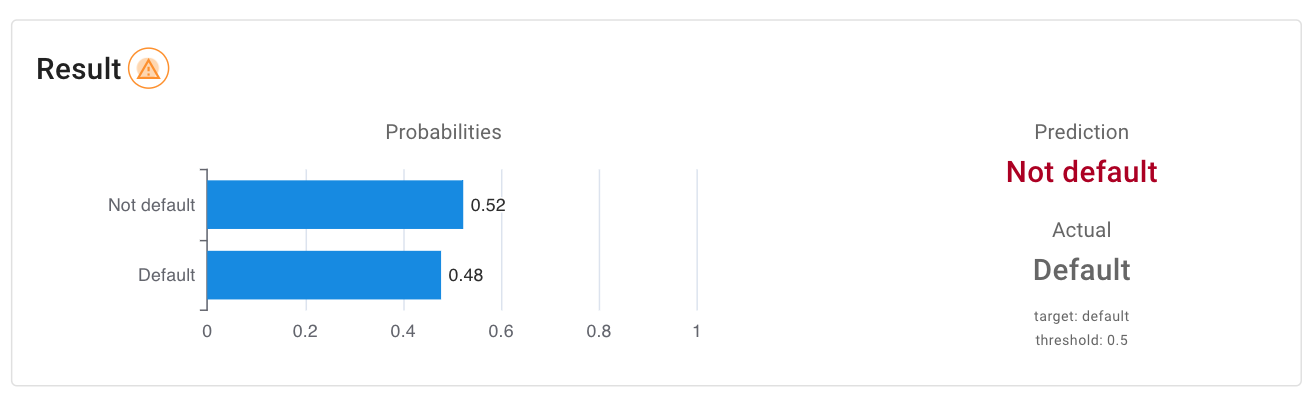

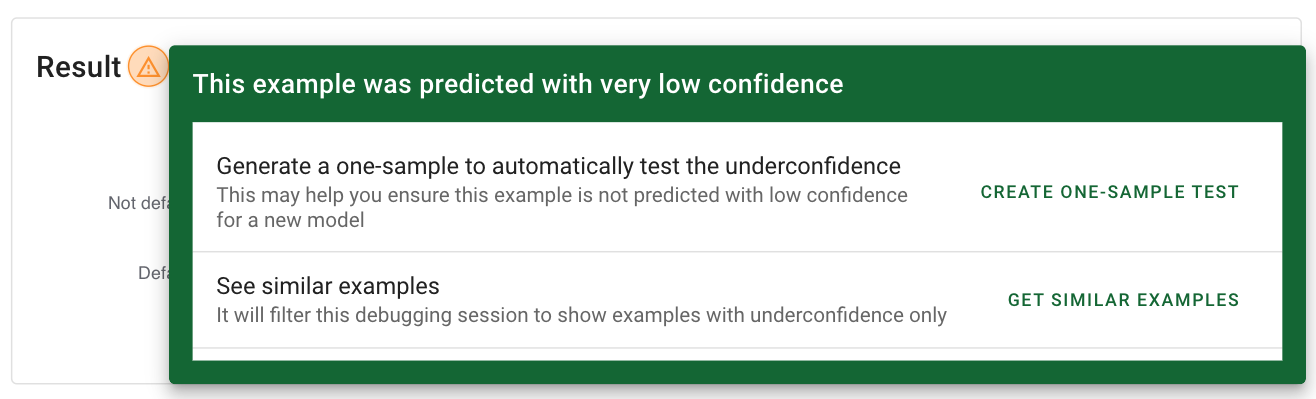

### Upload your test suite to the Giskard Hub

The entry point to the Giskard Hub is the upload of your test suite. Uploading the test suite will automatically save the model, dataset, tests, slicing & transformation functions to the Giskard Hub.

In [ ]:
# Create a Giskard client after having install the Giskard server (see documentation)
api_key = "<Giskard API key>" #This can be found in the Settings tab of the Giskard hub
#hf_token = "<Your Giskard Space token>" #If the Giskard Hub is installed on HF Space, this can be found on the Settings tab of the Giskard Hub

client = GiskardClient(
    url="http://localhost:19000",  # Option 1: Use URL of your local Giskard instance.
    # url="<URL of your Giskard hub Space>",  # Option 2: Use URL of your remote HuggingFace space.
    key=api_key,
    # hf_token=hf_token  # Use this token to access a private HF space.
)

project_key = "my_project"
my_project = client.create_project(project_key, "PROJECT_NAME", "DESCRIPTION")

# Upload to the project you just created
test_suite.upload(client, project_key)

### Download a test suite from the Giskard Hub

After curating your test suites with additional tests on the Giskard Hub, you can easily download them back into your environment. This allows you to:  

- Check for regressions after training a new model
- Automate the test suite execution in a CI/CD pipeline
- Compare several models during the prototyping phase

In [ ]:
test_suite_downloaded = Suite.download(client, project_key, suite_id=...)
test_suite_downloaded.run()